In [1]:
import numpy as np
import matplotlib.pyplot as plt
from heatmap_model.uncertainty_utils import *
%matplotlib inline
import pickle
import seaborn as sns
from scipy.optimize import curve_fit
import os

from skimage.transform import rescale, resize
from skimage import measure


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [ ]:
dt = np.load('interaction_merge/vis_train.npz')
radian_train = dt['radian']
origin_train = dt['origin']

with open('./poly_results/polygon_train.pkl', 'rb') as f:
    polygons_train = pickle.load(f)

with open('./poly_results/intersect.pkl', 'rb') as f:
    Nr = pickle.load(f)

scenario, V, polygons = read_polygons()
order, MAPS = read_map_order()
origin, radian = read_transform()
selected, cases = selected_trainset()

In [2]:
dt = np.load('./poly_results/area_lat72.npz')
A = dt['A']
scenario, V, _ = read_polygons()
with open('./poly_results/intersect.pkl', 'rb') as f:
    Nr = pickle.load(f)

Lat_inter = np.zeros((len(scenario), 30))
for i in tqdm(range(len(scenario))):
    for j in range(30):
        if 1. in Nr[i][j]:
            Lat_inter[i,j]=1

100%|██████████| 130346/130346 [00:00<00:00, 289665.42it/s]


In [ ]:
dt = np.load('./poly_results/area_lat515.npz')
A = dt['A']

In [ ]:
lc = np.where(scenario==1)[0]

flow = V/np.transpose(A, (0,2,1))*4*3.25*3600
Y = np.mean(flow[...,lc], -1)*4/3.1415
print(Y.shape)

In [3]:
lc = np.where((scenario>1)& (Lat_inter[:,-1]>0))[0]

flow = V/np.transpose(A, (0,2,1))*4*3.25*3600
Y = np.mean(flow[...,lc], -1)
print(Y.shape)

C:\Users\guope\AppData\Local\Temp\ipykernel_12436\4029763638.py:3: RuntimeWarning: divide by zero encountered in true_divide
  flow = V/np.transpose(A, (0,2,1))*4*3.25*3600
C:\Users\guope\AppData\Local\Temp\ipykernel_12436\4029763638.py:3: RuntimeWarning: invalid value encountered in true_divide
  flow = V/np.transpose(A, (0,2,1))*4*3.25*3600


(15, 30)


In [ ]:
flow = V/np.transpose(A, (0,2,1))*4*3.25*3600

Y = np.zeros((15,30))

for i in range(30):
    lc = np.where((scenario>1) & (Lat_inter[:,-1]>0))[0]
    Y[:,i] = np.mean(flow[:,i,lc], -1)
print(Y.shape)

C:\Users\guope\AppData\Local\Temp\ipykernel_12436\3135675526.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


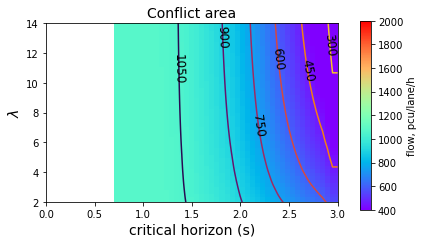

In [4]:
#Y = np.nan_to_num(Y)
Yr = resize(Y, (60, 60), anti_aliasing=True)
horizon = np.linspace(-0.05, 3.0, 60)
buffer = np.linspace(1, 15, 60)
#buffer = np.linspace(1, 15, 60)
X_, Y_ = np.meshgrid(horizon, buffer)
fig, ax = plt.subplots(figsize=(5,3.5))
rs1 = ax.pcolormesh(X_, Y_, Yr, cmap='rainbow', vmin=400, vmax=2000)
CS1 = ax.contour(X_, Y_, Yr, cmap='inferno_r')
ax.clabel(CS1,  inline=False, fontsize=12, colors = 'black')

ax.set_xlabel('critical horizon (s)', fontsize=14)
#ax.set_ylabel('k', fontsize=14)
ax.set_ylabel('$\lambda$', fontsize=14)
#ax.set_ylabel(r'$v_a$ (m/s)', fontsize=14)
cax = fig.add_axes([1.01, 0.15, 0.03, 0.75])
fig.colorbar(rs1, cax = cax, label='flow, pcu/lane/h', orientation='vertical')

ax.set_ylim(2, 14)
ax.set_xlim(0, 3.0)
#ax.set_title('Lane-changing', fontsize=14)
ax.set_title('Conflict area', fontsize=14)
plt.tight_layout()
#fig.savefig('./imgs/tradeoff_lat.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
Y = np.nan_to_num(Y)
np.amax(Y)

In [ ]:
A = get_scenario_based_offset_area(polygons, scenario, Nr, V, k=1.8, still_buffer=6, lateral_buffer=3.25)

In [ ]:
Lat_inter = np.zeros(len(scenario))
for i in tqdm(range(len(scenario))):
    if 1. in Nr[i][-1]:
        Lat_inter[i]=1

In [ ]:
A = np.zeros((15, len(V), 30))
for i in range(15):
    k = (6 +2*i)*0.1
    print(k)
    A[i] = get_scenario_based_offset_area(polygons, scenario, Nr, V, k, still_buffer=6, lateral_buffer=3.25)

In [ ]:
A = get_scenario_based_area(polygons, dx=0.5, buffer=None)

In [ ]:
np.savez_compressed('./poly_results/area_b', A = A)

In [ ]:
indices = np.where(scenario==1)[0]
p = np.polyfit(V[indices],V[indices]/A[indices,29],5)
xv = np.linspace(0,25,200)
#np.amax(np.polyval(p, xv))*3.25*3600
yv = np.polyval(p, xv)
Vx = np.linspace(0,25, 100)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(Vx, Vx/3.25/(Vx*1.8+6)*3600*3.25, zorder=99, lw=2, c='black', label='stable car-following')
ax.plot(xv, yv*4*3.25*3600/4*3.14, zorder=99, lw=2, c='red', ls='-', label = 'fitted from observations')
ax.scatter(V[indices], V[indices]/A[indices,-1]*4*3.25*3600/4*3.14, s=0.2, c='blue',marker='X')
plt.xlabel('speed (m/s)')
plt.ylabel('flow (pcu/lane/h)')
plt.title('Lane-changing')
plt.xlim(0, 30)
plt.ylim(0, 2000)
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/lane-changing.pdf', dpi=600)
plt.show()

In [ ]:
indices1 = np.where((scenario==3)&(Lat_inter>0))[0]
indices2 = np.where((scenario==3)&(Lat_inter==0))[0]
p = np.polyfit(V[indices1],V[indices1]/A[indices1,29],5)
xv = np.linspace(0,10,200)
#np.amax(np.polyval(p, xv))*3.25*3600
yv = np.polyval(p, xv)
p = np.polyfit(V[indices2],V[indices2]/A[indices2,29],5)
yv2 = np.polyval(p, xv)
Vx = np.linspace(0,25, 100)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(Vx, Vx/3.25/(Vx*1.8+6)*3600*3.25, zorder=99, lw=2, c='black', label='stable car-following')
ax.plot(xv, yv*4*3.25*3600/4*3.14, zorder=99, lw=2, c='blue', ls='-', label = 'in conflict zones')
ax.plot(xv, yv2*4*3.25*3600/4*3.14, zorder=99, lw=2, c='red', ls='-', label = 'not in conflict zones')
ax.scatter(V[indices1], V[indices1]/A[indices1,-1]*4*3.25*3600/4*3.14, s=0.2, marker='X')
ax.scatter(V[indices2], V[indices2]/A[indices2,-1]*4*3.25*3600/4*3.14, s=0.2, marker='X')
plt.xlabel('speed (m/s)')
plt.ylabel('flow (pcu/lane/h)')
plt.title('Roundabout')
plt.xlim(0, 30)
plt.ylim(0, 2000)
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/roundabout.pdf', dpi=600)
plt.show()

In [ ]:
K = 1/A[indices,-1]*4*3.25*3600/4*3.14
K>[V[indices]>15]
plt.scatter(1/A[indices,-1]*4*3.25*3600/4*3.14, V[indices]/A[indices,-1]*4*3.25*3600/4*3.14, s=0.2, marker='X')

In [ ]:
i1 = np.where(scenario==1)[0]
i2 = np.where(scenario==2)[0]
i3 = np.where(scenario==3)[0]

plt.rcParams["figure.figsize"] = (5,3.5)
plt.plot(np.arange(0.1, 3.1, 0.1), np.mean(A, 0))
plt.scatter(np.arange(0.1, 3.1, 0.1), np.mean(A, 0))
#plt.hlines(1.01, 0, 3.1,linestyles='dashed', label='added white noise')
plt.xlim(0,3.1)
plt.ylim(0,8)
plt.xlabel('t (s)',fontsize=14)
plt.ylabel(r'$\bar{A}\ (m^2)$',fontsize=14)
#plt.title('E(A)-t relationship',fontsize=14)
#plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
#plt.savefig('./imgs/EAt.pdf', dpi=600)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3.5))
#ax=fig.add_subplot(111)
extent = (0, 50, 0, 500)
ax.hist(A[:,-1]-2, bins=np.arange(0, 100, 2), color='black', alpha=0.5, density=True)
#axins = zoomed_inset_axes(ax,1,1, loc=1)#, axes_kwargs={'adjustable': 'box'})
axins = inset_axes(ax, 1.5,1.5 , loc=1)#, bbox_to_anchor=(6, 0.55))#,bbox_transform=ax.figure.transFigure) # no zoom
axins.hist(A[:,-1], bins=np.arange(0, 140, 2), color='black', alpha=0.5, density=True)
axins.yaxis.tick_left()
axins.set_xlim(30, 90)
axins.set_ylim(0, 0.001)
#ax.set_xlim(0.6, 3.1)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="black")
#plt.draw()
ax.set_xlabel('A ($m^2$)', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.set_title('Distribution of A(3s)', fontsize=12)
plt.tight_layout()
#ax.xaxis.set_label_coords(1.06, -0.075)
plt.savefig('./imgs/da3s.pdf', dpi=600)
plt.show()

In [ ]:
Y = np.zeros((15, 30))
xv = np.linspace(0,16,200)
for i in tqdm(range(30)):
    for j in range(11):
        p = np.polyfit(V,V/A[j,:,i]*4,2)
        Y[j,i] = np.amax(np.polyval(p, xv))

In [ ]:
len(scenario), len(polygons)

In [ ]:
S = np.mean(V/A.T*4, 1)*3.25*3600
plt.plot(1-S[0]/S)
#plt.plot(S)
plt.show()

In [ ]:
C = np.zeros(len(V))
for i in range(len(C)):
    speed = V[i]
    if speed <1.4:
        thd = 4
    elif speed > 11:
        thd = 8
    else:
        thd = 4*(speed-1.4)/(11-1.4) + 4
        
    space = A[i].copy()
    ind = np.where(space>thd)[0].tolist()
    if ind:
        if ind[0]>4:
            C[i] = (ind[0])*0.1
        else:
            C[i] = 3.0
    else:
        C[i] = 3.0

In [ ]:
fig, ax = plt.subplots(figsize=(6,3.5))
#ax=fig.add_subplot(111)
extent = (0, 50, 0, 500)
ax.hist(C, bins=np.arange(0,3.1,0.1), color='black', alpha=0.5, density=True)
#axins = zoomed_inset_axes(ax,1,1, loc=1)#, axes_kwargs={'adjustable': 'box'})
axins = inset_axes(ax, 2,1.5 , loc=2)#, bbox_to_anchor=(6, 0.55))#,bbox_transform=ax.figure.transFigure) # no zoom
axins.hist(C, bins=np.arange(0,3.1,0.1), color='black', alpha=0.5, density=True)
axins.yaxis.tick_right()
axins.set_xlim(0.4, 1.3)
axins.set_ylim(0, 0.04)
ax.set_xlim(0, 3.1)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="black")
#plt.draw()
ax.set_xlabel('t (s)', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.set_title('Distribution of the critical moment', fontsize=12)
ax.xaxis.set_label_coords(1.06, -0.075)
plt.savefig('./imgs/dch.pdf', dpi=600)
plt.show()

In [ ]:
Y = np.mean(V/np.transpose(A, (0, -1, -2)), -1)

In [ ]:
Yr1 = resize(Y1, (60, 60), anti_aliasing=True)
Yr2 = resize(Y2, (60, 60), anti_aliasing=True)
horizon = np.linspace(0.05, 3.0, 60)
# contours1 = measure.find_contours(Yr1, 1000)
# contours2 = measure.find_contours(Yr1, 1000)
buffer = np.linspace(0.6, 3.6, 60)
X_, Y_ = np.meshgrid(horizon, buffer)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
#rs = ax.contourf(X_, Y_, Yr, zorder=-1)
rs1 = ax[0].pcolormesh(X_, Y_, Yr1, cmap='rainbow', vmin=400, vmax=2000)
CS1 = ax[0].contour(X_, Y_, Yr1, cmap='inferno_r')
ax[0].clabel(CS1,  inline=False, fontsize=12, colors = 'black')

rs2 = ax[1].pcolormesh(X_, Y_, Yr2, cmap='rainbow', vmin=400, vmax=2000)
CS2 = ax[1].contour(X_, Y_, Yr2, cmap='inferno_r')
ax[1].clabel(CS2,  inline=False, fontsize=12, colors = 'black')
#ax.hlines(2.0, 0.05, 3.0)
#ax.plot(contours[0][:,1]/60*3+0.05, contours[0][:,0]/10-0.2, c='black', linestyle='--')
ax[0].set_xlabel('prediction horizon (s)', fontsize=14)
ax[1].set_xlabel('prediction horizon (s)', fontsize=14)
ax[0].set_ylabel('k (spacing)', fontsize=14)
#plt.text(1.5, 2., '1800', fontsize=12)
cax = fig.add_axes([1.01, 0.15, 0.02, 0.75])
fig.colorbar(rs2, cax = cax, label='Average efficiency, pcu/(lane$\cdot$h)', orientation='vertical')
#plt.yscale('log')
ax[0].set_ylim(0.8, 3.4)
ax[1].set_ylim(0.8, 3.4)
# ax[0].set_xlim(0, 3)
# ax[1].set_xlim(0, 3)
ax[0].set_title('Lane-changing', fontsize=14)
ax[1].set_title('Intersection/Roundabout', fontsize=14)
plt.tight_layout()
#fig.savefig('./imgs/tradeoff_s.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
Yr1 = resize(Y1, (60, 60), anti_aliasing=True)
Yr2 = resize(Y2, (60, 60), anti_aliasing=True)
horizon = np.linspace(0.05, 3.0, 60)
# contours1 = measure.find_contours(Yr1, 1000)
# contours2 = measure.find_contours(Yr1, 1000)
buffer = np.linspace(0.6, 3.6, 60)
X_, Y_ = np.meshgrid(horizon, buffer)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
#rs = ax.contourf(X_, Y_, Yr, zorder=-1)
rs1 = ax[0].pcolormesh(X_, Y_, Yr1, cmap='rainbow', vmin=400, vmax=2000)
CS1 = ax[0].contour(X_, Y_, Yr1, cmap='inferno_r')
ax[0].clabel(CS1,  inline=False, fontsize=12, colors = 'black')

rs2 = ax[1].pcolormesh(X_, Y_, Yr2, cmap='rainbow', vmin=400, vmax=2000)
CS2 = ax[1].contour(X_, Y_, Yr2, cmap='inferno_r')
ax[1].clabel(CS2,  inline=False, fontsize=12, colors = 'black')
#ax.hlines(2.0, 0.05, 3.0)
#ax.plot(contours[0][:,1]/60*3+0.05, contours[0][:,0]/10-0.2, c='black', linestyle='--')
ax[0].set_xlabel('prediction horizon (s)', fontsize=14)
ax[1].set_xlabel('prediction horizon (s)', fontsize=14)
ax[0].set_ylabel('k (spacing)', fontsize=14)
#plt.text(1.5, 2., '1800', fontsize=12)
cax = fig.add_axes([1.01, 0.15, 0.02, 0.75])
fig.colorbar(rs2, cax = cax, label='Average efficiency, pcu/(lane$\cdot$h)', orientation='vertical')
#plt.yscale('log')
ax[0].set_ylim(0.8, 3.4)
ax[1].set_ylim(0.8, 3.4)
# ax[0].set_xlim(0, 3)
# ax[1].set_xlim(0, 3)
ax[0].set_title('Lane-changing', fontsize=14)
ax[1].set_title('Intersection/Roundabout', fontsize=14)
plt.tight_layout()
#fig.savefig('./imgs/tradeoff_s.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
for i in range(11):
    S = np.mean(V/A[i].T*4, 1)*3600*3.25
    plt.plot((S[0]-S)/S)
plt.show()

In [ ]:
np.transpose(A, (0, -1, -2)).shape

In [ ]:
plt.plot(np.)

In [ ]:
p = np.polyfit(V,V/A[:,29],5)
xv = np.linspace(0,24,200)
#np.amax(np.polyval(p, xv))*3.25*3600
yv = np.polyval(p, xv)

In [ ]:
plt.scatter(V, V/A[:,29], s=0.2)
plt.scatter(V, V/A[:,0], s=0.2)
plt.plot(xv, yv, c='red')
plt.show()

In [ ]:
dt = np.load('interaction_merge/vis_valall.npz')

In [ ]:
from matplotlib import cm
from scipy import stats
case = 16
mapname = list(MAPS.keys())[case]
print(mapname)

def cond_mean(p):
    return p[p>1].mean()

indices = np.where(order==case)[0]
indices_t = np.where(np.array(cases)==case)[0]

locations_o = origin[indices]
pred_o = A[indices]

locations_t = origin_train[indices_t]
pred_t = At[indices_t]

locations = np.concatenate([locations_o, locations_t],0)
pred = np.concatenate([pred_o, pred_t])

binx = np.linspace(np.amin(locations[:,0]), np.amax(locations[:,0]), 70)
biny = np.linspace(np.amin(locations[:,1]), np.amax(locations[:,1]), 40)
ret = stats.binned_statistic_2d(locations[:,0], locations[:,1], pred, 'mean', bins=[binx, biny])

lanes = MAPS[mapname][0]

fig, ax = plt.subplots(figsize=(7,4.4))
for lane in lanes:
    layout = Polygon(lane)
    ax.plot(*layout.exterior.xy, c='grey', zorder=99)
#im = ax.scatter(locations[:,0], locations[:,1], c=pred/np.amax(pred), cmap=cm.rainbow, s=0.2)
im = ax.pcolormesh(binx, biny, ret.statistic.T, cmap='rainbow', vmin=0, vmax=18)
fig.colorbar(im, orientation='vertical', label=r'A(3s), $m^2$', fraction=0.046, pad=0.04)
fig.tight_layout()
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlim(965, 1065)
plt.ylim(965, 1030)
#plt.title(mapname[:-4], fontsize=14)
plt.savefig('./imgs/GL.png', dpi=600)
plt.show()